# Defining the STFT

In [3]:
%run ../setup.ipynb

The Short-Time Fourier Transform (STFT) does exactly what it says: it applies the Fourier transform to short fragments of time, that is, frames taken from a longer signal.
At a conceptual level, there is not too much going on here: we just extract frames from the signal, and apply the DFT to each frame.
However, there is much to discuss in the details.

## A basic STFT algorithm

A basic STFT algorithm requires three things:

- the input signal $\blue{x}$,
- the frame length $N_F$, and
- the hop length $N_H$.

Typical STFT implementations assume a real-valued input signal, and keep only the non-negative frequencies by using `rfft` instead of `fft`.
The result is a two-dimensional array, where one dimension indexes the frames, and the other indexes frequencies.
Note that the frame length dictates the number of samples going into the DFT, so the number of analysis frequencies will also be $N_F$.

````{margin}
```{warning}
This is probably not the STFT code you want to use in practice.

This implementation is intentionally simplified to illustrate the basic idea.
```
````

In [4]:
def basic_stft(x, n_frame, n_hop):
    '''Compute a basic Short-Time Fourier transform
    of a real-valued input signal.'''
    
    # Compute the number of frames
    frame_count = 1 + (len(x) - n_frame) // n_hop
    
    # Initialize the output array
    # We have frame_count frames 
    #     and (1 + n_frame//2) frequencies for each frame
    stft = np.zeros((frame_count, 1 + n_frame // 2), dtype=np.complex)
    
    # Populate each frame's DFT results
    for k in range(frame_count):
        # Slice the k'th frame
        x_frame = x[k * n_hop:k * n_hop + n_frame]
        
        # Take the DFT (non-negative frequencies only)
        stft[k, :] = np.fft.rfft(x_frame)
        
    return stft

{numref}`stft-animation` demonstrates the operation of this `basic_stft` method on a real audio recording.

<Figure size 576x432 with 9 Axes>

<Figure size 576x432 with 9 Axes>

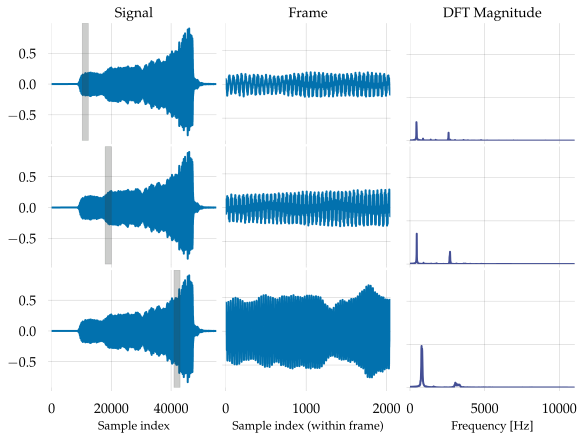

In [11]:
import soundfile

fig, ax = plt.subplots(ncols=3, nrows=3, sharex='col', sharey='col', figsize=(8, 6))

x, fs = soundfile.read('517633__samuelgremaud__slide-whistle-1-mono.wav')

# Trim to 2.5 seconds
x = x[:int(2.5*fs)]

N_F = 2048
N_H = 512

S = np.abs(basic_stft(x, N_F, N_H))

n = np.arange(N_F)
freqs = np.fft.rfftfreq(N_F, 1/fs)

for (frame, k) in enumerate([20, 35, 80]):
    
    ax[frame, 0].plot(x)
    ax[frame, 0].axvspan(k * N_H, k*N_H+N_F, color=colors[3], alpha=0.25, zorder=5) 
    ax[frame, 0].set(xlabel='Sample index')
    ax[frame, 1].step(n, x[k*N_H:k*N_H+N_F], where='post')[0]
    ax[frame, 1].set(ylim=[x.min(), x.max()], xlabel='Sample index (within frame)')
    ax[frame, 2].plot(freqs, S[k], color=colors[11])[0]
    ax[frame, 2].set(ylim=[0, S.max()], xlabel='Frequency [Hz]')
    ax[frame, 0].label_outer()
    ax[frame, 1].label_outer()
    ax[frame, 2].label_outer()

ax[0, 0].set(title='Signal')
ax[0, 1].set(title='Frame')
ax[0, 2].set(title='DFT Magnitude')
    
glue('stft', fig, display=False)

In [6]:
display(Audio(filename='517633__samuelgremaud__slide-whistle-1-mono.wav'))

```{glue:figure} stft
:name: stft-animation

A signal $\blue{x}$ is sampled at $f_s=22050$ and frames are taken with $N_F=2048$ and $N_H=512$.
Each frame of $\blue{x[n]}$ (*left) is plotted (*middle*) along with its DFT magnitudes $|\darkblue{X[m]}|$ as produced by the STFT (*right*).
```

The type of visualization used in {numref}`stft-animation` may look familiar to you, as it can be found on all kinds of commercially available devices (stereos, music software, etc.).  Now you know how it works.

## Spectrograms

Another way of representing the output of a Short-Time Fourier transform is by using **spectrograms**.
Spectrograms are essentially an image representation of the STFT, constructed by stacking the frames horizontally, so that time can be read left-to-right, and frequency can be read bottom-to-top.
Typically, when we refer to *spectrograms*, what we actually mean are *magnitude spectrograms*, where the phase component has been discarded and only the DFT magnitudes are retained.
In Python code, we would say:

```{code-block} python
# Compute the STFT with frame length = 1024, hop length = 512
stft = basic_stft(x, 1024, 512)

# Take the absolute value to discard phase information
S = np.abs(stft)
```

This allows us to interpret energy ($\darkblue{S=|X|}$) visually as brightness under a suitable color mapping.

{numref}`spectrogram-fig` (top) illustrates an example of a spectrogram display.  Each column (vertical slice) of the image corresponds to one frame of {numref}`stft-animation` (right).

<Figure size 432x324 with 4 Axes>

<Figure size 432x324 with 4 Axes>

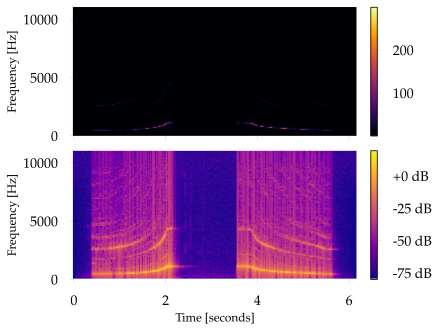

In [14]:
# https://freesound.org/s/517633/
x, fs = soundfile.read('517633__samuelgremaud__slide-whistle-1-mono.wav')

N_F = 1024
N_H = 512
X = basic_stft(x, N_F, N_H)
fig, (ax0, ax) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=figaspect(0.75))

times = np.arange(X.shape[0]) * N_H / fs
freqs = np.fft.rfftfreq(N_F, 1/fs)

img = ax0.pcolormesh(times, freqs, np.abs(X.T), shading='nearest', rasterized=True, cmap='inferno')
ax0.grid(False)
ax0.set(xlabel='Time [seconds]', ylabel='Frequency [Hz]')
ax0.label_outer()

fig.colorbar(img, ax=[ax0])

spec_db = 20 * np.log10(np.abs(X)/np.sqrt(N_F) + 1e-4)
imgdb = ax.pcolormesh(times, freqs, spec_db.T, shading='nearest', rasterized=True)
ax.grid(False)
ax.set(xlabel='Time [seconds]', ylabel='Frequency [Hz]')

fig.colorbar(imgdb, format='%+2.0f dB', ax=[ax])

glue('spectrogram', fig, display=False)

```{glue:figure} spectrogram
:name: spectrogram-fig
:alt: A magnitude spectrogram in linear and logarithmic (decibel) scale

The *magnitude spectrogram* representation of the slide whistle example of {numref}`stft-animation`, using the same parameters $N_F=1024$, $N_H=512$.
**Top**: visualization using linear magnitude scaling.
**Bottom**: visualization using decibel scaling.
```

While some spectral content is visually perceptible in {numref}`spectrogram-fig` (top), most of the image is dark, and it's generally difficult to read.
This goes back our earlier discussion of {ref}`decibels <decibels>`: human perception of amplitude is logarithmic, not linear, so we should account for this when visualizing spectral content.

The bottom plot of {numref}`spectrogram-fig` shows the same data, but using a decibel scaling for amplitudes:
````{margin} Calculating dB
The decibel calculation in {numref}`spectrogram-fig` is actually a bit more detailed.

First, the spectrogram magnitudes are normalized by $S \rightarrow S / \sqrt{N_F}$.
This ensures that spectrograms of different frame lengths will have comparable magnitude scales.
This normalization does not change the visual characteristics of the plot, only the interpretation of the colors.

Second, to avoid numerical underflow when taking the log of small numbers (close to 0), a bias offset of $10^{-4}$ is added.
This ensures that the dB measurement is always at least 
```{math}
20\cdot\log_{10} 10^{-4} = -80,
```
which prevents the visual scale from being skewed by inaudible artifacts.

The total dB calculation is more accurately represented as
```{math}
S_\text{dB} = 20\cdot \log_{10} \left(S / \sqrt{N_F} + 10^{-4} \right).
```
````
```{math}
S_\text{dB} = 20\cdot \log_{10} S
```

The result of this mapping exposes far more structure in the input signal.
The (frame-wise) fundamental frequency of the signal is visually salient as the bright contour at the bottom of the image, but harmonics are also visible, as is background noise.

## Choosing parameters

The `basic_stft` algorithm above has two parameters that we are free to set however we see fit.
There is no single "right" setting for these STFT parameters, but there are settings that will be better or worse for certain applications.

### Frame length $N_F$

Unlike the standard DFT, where the number of analysis frequencies is dictated by the number of samples, the STFT allows us to control this parameter directly.
This introduces a **time-frequency** trade-off.

Large values of $N_F$ will provide a high frequency resolution, dividing the frequency range $[0, f_s/2]$ into smaller pieces as $N_F$ increases.
This comes at a cost of reduced time resolution: large values of $N_F$ integrate over longer windows of time, so any changes in frequency content that are shorter than the frame length could be obscured.
Intuitively, when the frame length is large (and the hop length is fixed), any given sample $x[n]$ will be covered by more frames, and therefore contribute to more columns in the spectrogram, resulting in a blurring over time.

Conversely, small values of $N_F$ provide good time localization---since each frame only sees a small amount of information---but poor frequency resolution, since the range $[0, f_s/2]$ is divided into relatively few pieces.

{numref}`stft-nframe` visualizes this trade-off for a fixed hop length $N_H$ and varying frame length $N_F$.

<Figure size 576x360 with 10 Axes>

<Figure size 576x360 with 10 Axes>

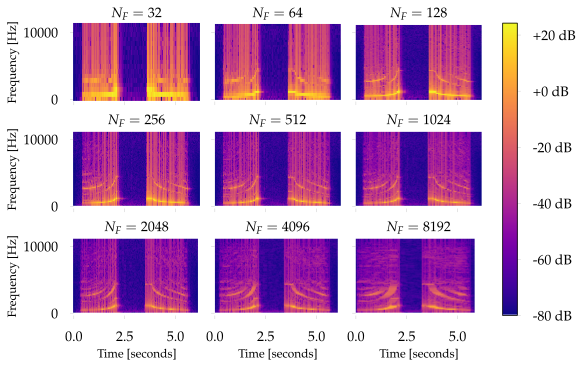

In [17]:
x, fs = soundfile.read('517633__samuelgremaud__slide-whistle-1-mono.wav')

N_F = 2048
N_H = 512

fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(8, 5))

for i, N_F in enumerate([32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]):

    X = basic_stft(x, N_F, N_H)
    spec_db = 20 * np.log10(np.abs(X)/np.sqrt(N_F) + 1e-4)

    times = np.arange(X.shape[0]) * N_H / fs
    freqs = np.fft.rfftfreq(N_F, 1/fs)

    imgdb = ax.flat[i].pcolormesh(times, freqs, spec_db.T, shading='nearest', rasterized=True)
    ax.flat[i].grid(False)
    ax.flat[i].set_title(f'$N_F={N_F}$')
    ax.flat[i].set(xlabel='Time [seconds]', ylabel='Frequency [Hz]')
    ax.flat[i].label_outer()

fig.colorbar(imgdb, ax=ax, format='%+2.0f dB')
glue('stft-nframe', fig, display=False)

```{glue:figure} stft-nframe
:name: stft-nframe

Changing the frame length $N_F = 32, 64, 128, \dots, 8192$ illustrates the time-frequency trade-off.
At low frame lengths, energy spreads out vertically along the frequency axis; at large frame lengths, it spreads horizontally along the time axis.
For intermediate values of $N_F$, this spread is relatively balanced, providing a clear representation of the time-varying frequency content of the signal.
All analyses here use $N_H=512$ and $f_s = 22050$.
```

As a general rule, it is common to choose $N_F$ to be an integral power of 2 (e.g., 1024, 2048, etc.).
This is almost entirely done for efficiency purposes, as it allows for the use of the {ref}`radix-2 FFT <radix2-fft>` algorithm.
However, this is not a *requirement* of the STFT: any frame length $N_F>0$ will work.

```{tip}
In typical audio applications, absent any other constraints, one heuristic for choosing the frame length is to ensure that it is long enough to observe at least a few cycles at the low end of the audible frequency range (which have the longest periods: $t_0 = 1/f_0$).

If we assume that humans can perceive frequency down to 20 Hz, this frequency has period $1/20 = 0.05$ [seconds], so two cycles would take 0.1 seconds.
If the sampling rate is $f_s = 44100$ (so that the Nyquist frequency is above the upper limit of audible frequencies of 20000 [Hz]), then a frame length $N_F = 4096$ would have duration $N_F / f_s \approx 0.093$ [seconds], which is pretty close to 0.1.

Note that this is just a heuristic, and not a rule: other choices for $N_F$ may be more appropriate for different situations, but this line of reasoning can lead you to a reasonable starting place.
```

### Hop length $N_H$

The hop length parameter behaves a bit differently from the frame length parameter, as it has no bearing on the frequency resolution of the STFT.
All it controls is how often we compute the DFT, so an STFT with a large hop length can be understood as a decimation (in time) of an STFT with a small hop length.

Small values of the hop length produce highly redundant outputs, meaning that the (magnitude) spectrogram at frame $k$ is similar to that of $k+1$ if $N_H$ is small.
This makes sense if we're assuming that frequency content is locally consistent and not changing too rapidly.
Redundancy isn't necessarily a bad thing, but it does require more memory and more processing: remember, the number of frames in an STFT scales like $N / N_H$ (ignoring constants and boundary effects).

Larger values of hop length provide coarser time resolution.
Note, however, that if $N_H > N_F$ (that is, we hop by more than a frame length each time), then **some samples will not be covered by any frame**.
This would potentially lose information, especially due to transients that fall between frames.
It is commonly recommended, therefore, to set $N_H$ as a constant fraction of $N_F$, typically either 1/8, 1/4, or 1/2.
```{margin} Frame overlap
Many STFT implementations (and reference texts) do not expose the hop length parameter directly, but require it to be set as a fraction of the frame length.
For example, you may see STFT implementations like `scipy.signal.stft`, that take an `overlap` parameter instead of a hop length.

We have decided here to describe the STFT in terms of the hop length parameter for two reasons.
First, it avoids any ambiguity due to rounding when multiplying the overlap ratio by the frame length.
Second, it more naturally connects to how a dynamic STFT would be implemented when an audio stream is captured in real time.
```
This ensures that no samples are lost in the STFT, and due to overlapping frames, the resulting STFT should vary smoothly.

{numref}`stft-nhop` illustrates the effects of varying hop length for a fixed frame length.

<Figure size 576x360 with 10 Axes>

<Figure size 576x360 with 10 Axes>

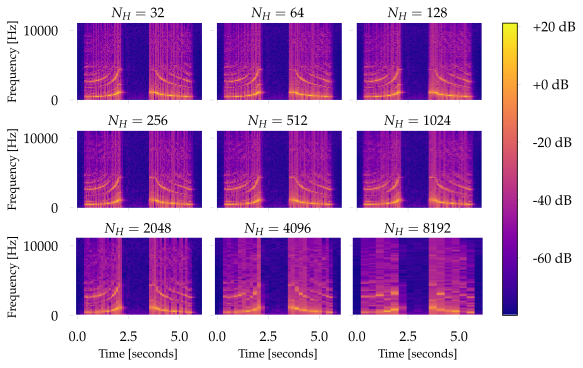

In [15]:
x, fs = soundfile.read('517633__samuelgremaud__slide-whistle-1-mono.wav')

N_F = 2048
N_H = 512

fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(8, 5))

for i, N_H in enumerate([32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]):

    X = basic_stft(x, N_F, N_H)
    spec_db = 20 * np.log10(np.abs(X)/np.sqrt(N_F) + 1e-4)

    times = np.arange(X.shape[0]) * N_H / fs
    freqs = np.fft.rfftfreq(N_F, 1/fs)

    imgdb = ax.flat[i].pcolormesh(times, freqs, spec_db.T, shading='nearest', rasterized=True)
    ax.flat[i].grid(False)
    ax.flat[i].set_title(f'$N_H={N_H}$')
    ax.flat[i].set(xlabel='Time [seconds]', ylabel='Frequency [Hz]')
    ax.flat[i].label_outer()

fig.colorbar(imgdb, ax=ax, format='%+2.0f dB')
glue('stft-nhop', fig, display=False)

```{glue:figure} stft-nhop
:name: stft-nhop

Changing the hop length $N_H = 32, 64, 128, \dots, 8192$.
At small hop lengths, we have a dense sampling in time of the frequency content, and a high resolution image.
At large hop lengths, the time resolution is decreased because frames are taken less frequently.
However, the frequency resolution remains the same.
All analyses here use $N_F=2048$ and $f_s = 22050$.
```

## Windowing

An astute observer might notice in {numref}`stft-nframe` and {numref}`stft-nhop` that there are vertical banding artifacts in the spectrograms, which suggest broad-band bursts of energy across the entire frequency spectrum which are typically associated with transient events, e.g., percussion or other abrupt discontinuities in the signal.
However, the input signal consists of a continuously varying pitch played on a slide whistle with no discernible transients.  What's going on?

These artifacts are due to {ref}`spectral leakage <leakage>`: for a fixed frame length $N_F$, it's unlikely that a period signal will line up exactly with the frame boundaries.
As we saw perviously, the DFT will use sinusoids of all available analysis frequencies to explain the abrupt discontinuity that would occur if the frame was looped indefinitely, and this results in a distorted view of the signal through the STFT.

We can resolve this by using {ref}`windowing <windowing>`: sample-wise multiplying the framed signal by a curve that tapers to 0 at the beginning and end so that the looped frame appears continuous.
```{margin}
The **window** goes in the **frame**.  Get it?
```
It is common for STFT implementations to provide this feature, as illustrated below by `wstft`:

In [15]:
def wstft(x, n_frame, n_hop, window):
    '''Compute a windowed Short-Time Fourier transform
    
    Parameters
    ----------
    x : the input signal (real-valued)
    
    n_frame : the frame length (in samples)
    
    n_hop : the hop length (in samples)
    
    window : a window specification
        e.g., "hann" or ("kaiser", 4.0)
        
        See scipy.signal.get_window for details
        
    Returns
    -------
    stft : the Short-Time fourier transform of x (complex-valued)
        Shape: (frame_count, 1 + n_hop // 2)
    '''
    
    # Compute the number of frames
    frame_count = 1 + (len(x) - n_frame) // n_hop
    
    # Initialize the output array
    # We have frame_count frames and (1 + n_frame//2) frequencies for each frame
    X = np.zeros((frame_count, 1 + n_frame // 2), dtype=np.complex)
    
    # We'll use scipy's window constructor here
    window = scipy.signal.get_window(window, n_frame)
    
    # Populate each frame's DFT results
    for k in range(frame_count):
        # Slice the k'th frame, apply a window, and take its DFT
        X[k, :] = np.fft.rfft(x[k * n_hop:k * n_hop + n_frame] * window)
        
    return X

To use the windowed STFT, one must provide the choice of window (typically by name), for example:

```{code-block} python
# Use a Hann window
stft = wstft(x, 2048, 512, 'hann')

# A 'rectangular' window is equivalent to no window at all
stft_nowin = wstft(x, 2048, 512, 'rectangular')
```

The implementation above uses [`scipy.signal.get_window`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html#scipy.signal.get_window) to construct the specified window, and many choices are available.

{numref}`stft-windowing` illustrates the difference between a Hann-windowed and non-windowed STFT.

```{tip}
Always use windowing in your STFT, unless you have a strong reason not to.
```

<Figure size 432x324 with 4 Axes>

<Figure size 432x324 with 4 Axes>

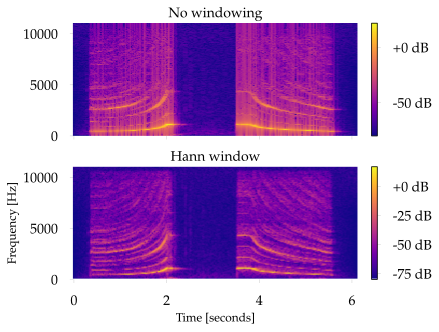

In [16]:
# https://freesound.org/s/517633/
x, fs = soundfile.read('517633__samuelgremaud__slide-whistle-1-mono.wav')

N_F = 2048
N_H = 512

fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=figaspect(0.75))

X = basic_stft(x, N_F, N_H)
times = np.arange(X.shape[0]) * N_H / fs
freqs = np.fft.rfftfreq(N_F, 1/fs)

spec_db = 20 * np.log10(np.abs(X)/np.sqrt(N_F) + 1e-4)
imgdb = ax.pcolormesh(times, freqs, spec_db.T, shading='nearest', rasterized=True)
ax.grid(False)
ax.label_outer()
ax.set_title('No windowing')

fig.colorbar(imgdb, format='%+2.0f dB', ax=[ax])

Xw = wstft(x, N_F, N_H, 'hann')

spec_db = 20 * np.log10(np.abs(Xw)/np.sqrt(N_F) + 1e-4)
imgdb = ax2.pcolormesh(times, freqs, spec_db.T, shading='nearest', rasterized=True)
ax2.grid(False)
ax2.set(xlabel='Time [seconds]', ylabel='Frequency [Hz]')
ax2.set_title('Hann window')

fig.colorbar(imgdb, format='%+2.0f dB', ax=[ax2])

glue('stft-windowing', fig, display=False)

```{glue:figure} stft-windowing
:name: stft-windowing
:alt: A spectrogram with and without windowing

**Top**: An STFT computed using `basic_stft` without any windowing.
**Bottom**: A windowed STFT computed by `wstft` with `window='hann'`.
The windowed STFT has significantly less spectral leakage, which reduces the vertical banding artifacts, and makes harmonic structure more visible.
Both analyses use $N_F=2048$, $N_H=512$, and $f_s = 22050$.
```

## Summary

The STFT provides a way to apply Fourier analysis locally to small fragments of a long signal, thereby relaxing the assumption that frequency content is stationary over the duration of the signal.
It therefore has become a standard starting point for all kinds of signal processing tasks, especially those involving real-time signal acquisition.
While it may look a bit complicated at first, with experience, people can learn to "read" spectrogram visualizations and identify properties and contents of an audio signal by visual inspection alone.